# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
import jax
import jax.numpy as jnp
import sys
sys.path.append("../")  
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

In [2]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 200

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 789 ms, sys: 282 ms, total: 1.07 s
Wall time: 1.29 s


In [3]:
# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')

Component 0: GridVariable(array=GridArray(data=array([[[-0.18852493, ..., -0.2654644 ],
        ...,
        [-0.21095662, ..., -0.28699297]],

       ...,

       [[ 0.38273215, ...,  0.3598501 ],
        ...,
        [ 0.38491708, ...,  0.36165518]]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[ 0.06907266, ...,  0.09150431],
        ...,
        [ 0.08111213, ...,  0.1036693 ]],

       ...,

       [[-0.4152452 , ..., -0.41743013],
        ...,
        [-0.4104835 , ..., -0.41201428]]], dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=Homogeneo

In [4]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

In [5]:
ds

<xarray.Dataset> Size: 105MB
Dimensions:  (time: 200, x: 256, y: 256)
Coordinates:
  * x        (x) float32 1kB 0.01227 0.03682 0.06136 ... 6.222 6.246 6.271
  * y        (y) float32 1kB 0.01227 0.03682 0.06136 ... 6.222 6.246 6.271
  * time     (time) float64 2kB 0.0 0.1534 0.3068 0.4602 ... 30.22 30.37 30.53
Data variables:
    u        (time, x, y) float32 52MB -0.1885 -0.1094 ... 0.3376 0.3617
    v        (time, x, y) float32 52MB 0.06907 0.04583 ... -0.4131 -0.412

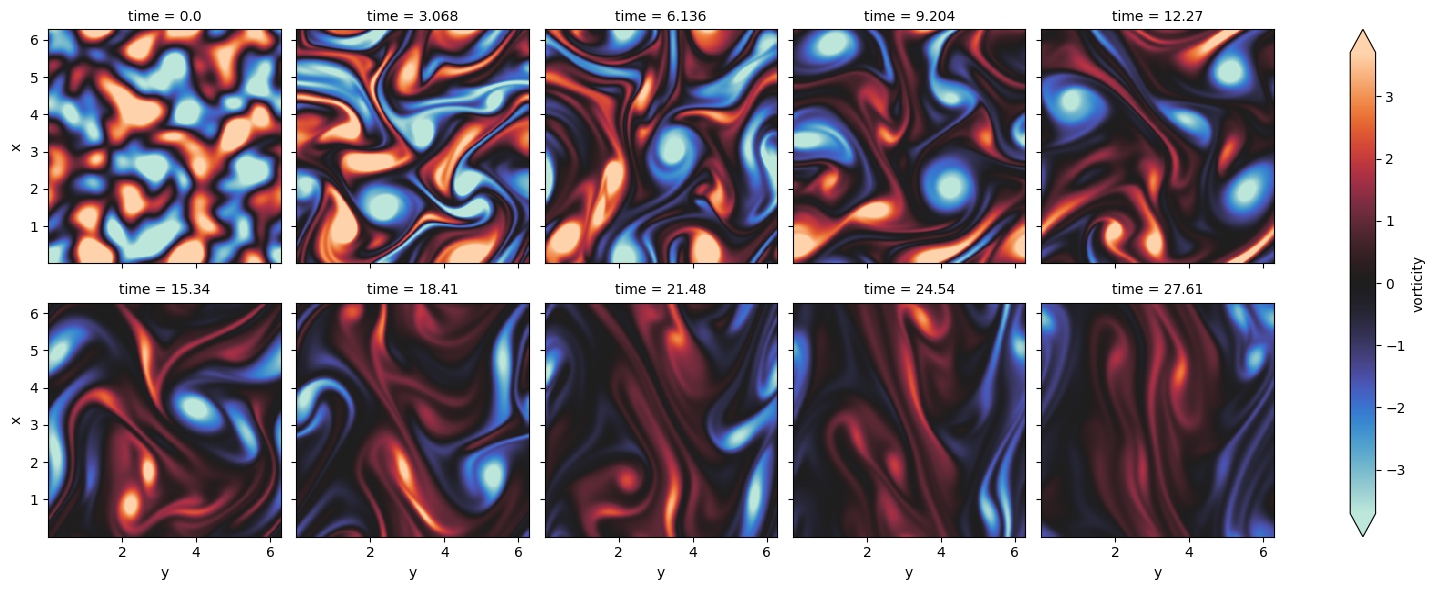

In [6]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));